# CVAE

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import utils
from tqdm.auto import tqdm
import tensorflow as tf

class CVAE(object):
    """Conditional Variational Auto Encoder (CVAE)."""

    def __init__(self, n_latent, n_hidden=50, alpha=0.2):
        self.n_latent = n_latent
        self.n_hidden = n_hidden
        self.alpha = alpha

    def lrelu(self, x, alpha=0.3):
        return tf.maximum(x, tf.multiply(x, alpha))

    def encoder(self, X_in, cond, input_dim):
        with tf.variable_scope("encoder", reuse=None):
            x = tf.concat([X_in, cond], axis=1)
            x = tf.contrib.layers.flatten(x)
            x = tf.layers.dense(x, units=self.n_hidden, activation=self.lrelu)
            mn = tf.layers.dense(x, units=self.n_latent, activation=self.lrelu)
            sd = tf.layers.dense(x, units=self.n_latent, activation=self.lrelu)
            epsilon = tf.random_normal(tf.stack([tf.shape(x)[0], self.n_latent]))
            z = mn + tf.multiply(epsilon, tf.exp(sd / 2.))

            return z, mn, sd

    def decoder(self, sampled_z, cond, input_dim):
        with tf.variable_scope("decoder", reuse=None):
            x = tf.concat([sampled_z, cond], axis=1)
            x = tf.layers.dense(x, units=self.n_hidden, activation=self.lrelu)
            x = tf.layers.dense(x, units=input_dim, activation=tf.nn.sigmoid)
            x = tf.reshape(x, shape=[-1, input_dim])

            return x

    def train(self, data, data_cond, n_epochs=10000, learning_rate=0.005,
              show_progress=False):

        data = utils.as_float_array(data)
        data_cond = utils.as_float_array(data_cond)

        if len(data_cond.shape) == 1:
            data_cond = data_cond.reshape(-1, 1)

        assert data.max() <= 1. and data.min() >=0., \
            "All features of the dataset must be between 0 and 1."

        tf.reset_default_graph()

        input_dim = data.shape[1]
        dim_cond = data_cond.shape[1]

        X_in = tf.placeholder(dtype=tf.float32, shape=[None, input_dim],
                              name="X")

        self.cond = tf.placeholder(dtype=tf.float32, shape=[None, dim_cond],
                                   name="c")
        Y = tf.placeholder(dtype=tf.float32, shape=[None, input_dim],
                           name="Y")

        Y_flat = Y

        self.sampled, mn, sd = self.encoder(X_in, self.cond, input_dim=input_dim)
        self.dec = self.decoder(self.sampled, self.cond, input_dim=input_dim)

        unreshaped = tf.reshape(self.dec, [-1, input_dim])
        decoded_loss = tf.reduce_sum(tf.squared_difference(unreshaped, Y_flat), 1)
        latent_loss = -0.5 * tf.reduce_sum(1. + sd - tf.square(mn) - tf.exp(sd), 1)

        self.loss = tf.reduce_mean((1 - self.alpha) * decoded_loss + self.alpha * latent_loss)

        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())

        for i in tqdm(range(n_epochs), desc="Training"):
            self.sess.run(optimizer, feed_dict={X_in: data, self.cond: data_cond, Y: data})
            if not i % 1000 and show_progress:
                ls, d = self.sess.run([self.loss, self.dec], feed_dict={X_in: data, self.cond: data_cond, Y: data})

                projections = np.random.randint(0, data.shape[1], size=2)

                plt.scatter(data[:, projections[0]], data[:, projections[1]])
                plt.scatter(d[:, projections[0]], d[:, projections[1]])
                plt.show()

                print(i, ls)

    def generate(self, cond, n_samples=None):
        cond = utils.as_float_array(cond)

        if n_samples is not None:
            randoms = np.random.normal(0, 1, size=(n_samples, self.n_latent))
            cond = [list(cond)] * n_samples
        else:
            randoms = np.random.normal(0, 1, size=(1, self.n_latent))
            cond = [list(cond)]

        samples = self.sess.run(self.dec, feed_dict={self.sampled: randoms, self.cond: cond})

        if n_samples is None:
            return samples[0]

        return samples

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.preprocessing import MinMaxScaler


ModuleNotFoundError: No module named 'base'

## Create the data

In [ ]:
data, conditions = make_circles(n_samples=10000, noise=0.05, factor=0.5)

# We normalise the data to [0, 1]^2
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

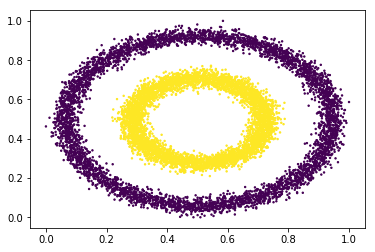

In [ ]:
# Plot dataset
plt.scatter(*data.T, c=conditions, s=2)
plt.show()

# Train the CVAE

In [ ]:
generator = cvae.CVAE(n_latent=4, alpha=0.02)
generator.train(data, data_cond=conditions.reshape(-1, 1),
                n_epochs=10000)

Training: 100%|██████████| 10000/10000 [03:19<00:00, 50.11it/s]


# Generate samples

In [ ]:
outer_circle_generated = generator.generate((0,), n_samples=1000)
inner_circle_generated = generator.generate((1,), n_samples=1000)

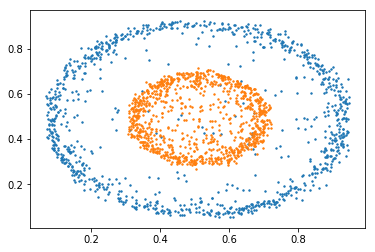

In [ ]:
plt.scatter(*outer_circle_generated.T, s=2)
plt.scatter(*inner_circle_generated.T, s=2)
plt.show()